# Full Grid Evolution using Tensor Contraction.
## 2D EA 

In [1]:
import torch
import numpy as np
import numba as nb
from scipy.linalg import sqrtm

In [2]:
import math
import time
from tqdm.auto import trange

In [3]:
from collections import defaultdict
import copy
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [4]:
def j_matrix_init():
    global j_matrix
    #np.random.seed(1288688)
    j_matrix = np.zeros((dims[0], dims[1], 4), dtype=np.int8)
    for i in range(dims[0]):
        for j in range(dims[1]):
            j_matrix[i][j] = (-1) ** np.random.binomial(1, 1/2, 4)
    for i in range(dims[0]):
        for j in range(dims[1]):
            j_matrix[i][j][3] = j_matrix[(i-1)%dims[0]][j][1]
            j_matrix[i][j][0] = j_matrix[i][(j-1)%dims[1]][2]

In [5]:
def j_pos_one_matrix_init():
    global j_matrix
    j_matrix = np.ones((dims[0], dims[1], 4), dtype=np.float64)

In [6]:
def j_neg_one_matrix_init():
    global j_matrix
    j_matrix = -1 * np.ones((dims[0], dims[1], 4), dtype=np.float64)    

In [7]:
def j_matrix_frust_init():
    global j_matrix
    j_matrix = np.ones((dims[0], dims[1], 4), dtype=np.int8)
    for i in range(dims[0]):
        for j in range(dims[1]):
            if j % 2 != 0:
                j_matrix[i][j][1] = -1
                j_matrix[i][j][3] = -1
    for i in range(dims[0]):
        for j in range(dims[1]):
            j_matrix[i][j][3] = j_matrix[(i-1)%dims[0]][j][1]
            j_matrix[i][j][0] = j_matrix[i][(j-1)%dims[1]][2]

In [8]:
def B_tensor_prepare(j_vec):
    B_list = []
    for jj in j_vec:
        if jj == 1:
            B_list.append(B_pos)
        else:
            B_list.append(B_neg)
    return B_list

In [9]:
def bdy_vector_prepare(grid, id_loc, pos_index):
    """
    Args:
        grid: (np.array)
        id_loc: (tuple)
        pos_index: (int) 
        
    Returns:
        bdy_vector: (np.array)
    """
    id_row, id_col = id_loc
    if grid[id_row][id_col] == 1:
        if j_matrix[id_row][id_col][pos_index] == 1:
            bdy_vector = spin_pos_up
        else:
            bdy_vector = spin_neg_up
    else:
        if j_matrix[id_row][id_col][pos_index] == 1:
            bdy_vector = spin_pos_down
        else:
            bdy_vector = spin_neg_down
    return bdy_vector

In [10]:
def parameters_init(dims_init, beta_init, h_init):
    global grid_1, grid_2, dims, beta, h
    #np.random.seed(314)
    #np.random.seed(181)
    #np.random.seed(0)
    dims = (nb.int64(dims_init[0]), nb.int64(dims_init[1]))
    beta, h = nb.float64(beta_init), nb.float64(h_init)
    grid_1 = np.reshape(np.random.choice([nb.int8(-1), nb.int8(1)], 
                                         size=dims_init[0]*dims_init[1]), dims_init)
    grid_2 = np.reshape(np.random.choice([nb.int8(-1), nb.int8(1)], 
                                         size=dims_init[0]*dims_init[1]), dims_init)

In [11]:
global grid_1, grid_2, dims, beta, j_matrix, h

In [12]:
dims_init = (4, 4)
#dims_init = (8, 8)
#dims_init = (16, 16)
#dims_init = (32, 32)
#dims_init = (64, 64)
#beta_init, h_init = np.log(1 + np.sqrt(2)) / 2, 0
beta_init, h_init = 3, 0
parameters_init(dims_init, beta_init, h_init)

In [13]:
j_matrix_frust_init()
#j_matrix_init()
#j_neg_one_matrix_init()
#j_pos_one_matrix_init()

In [14]:
my_device = torch.device('cuda:5') if torch.cuda.is_available() else torch.device('cpu')
#my_device = torch.device('cpu')

In [15]:
def node_tensor_create(my_device=my_device):
    I_1, I_2, I_3, I_4, I_up, I_down = copy_tensor_create(my_device)
    B_pos = torch.tensor(sqrtm(np.array([[np.exp(beta),np.exp(-beta)], 
                                         [np.exp(-beta),np.exp(beta)]])), 
                         dtype=torch.complex128, device=my_device)
    B_neg = torch.tensor(sqrtm(np.array([[np.exp(-beta),np.exp(beta)], 
                                         [np.exp(beta),np.exp(-beta)]])), 
                         dtype=torch.complex128, device=my_device)
    spin_up = torch.tensor([1, 0], dtype=torch.complex128, device=my_device)
    spin_down = torch.tensor([0, 1], dtype=torch.complex128, device=my_device)
    spin_pos_up = torch.einsum("i, ij -> j", [spin_up, B_pos])
    spin_pos_down = torch.einsum("i, ij -> j", [spin_down, B_pos])
    spin_neg_up = torch.einsum("i, ij -> j", [spin_up, B_neg])
    spin_neg_down = torch.einsum("i, ij -> j", [spin_down, B_neg])
    return B_pos, B_neg, spin_pos_up, spin_pos_down, spin_neg_up, spin_neg_down

In [16]:
def copy_tensor_create(my_device=my_device):
    I_2_array = np.zeros((2, 2))
    I_3_array = np.zeros((2, 2, 2))
    I_4_array = np.zeros((2, 2, 2, 2))
    I_up_array = np.zeros((2, 2, 2, 2))
    I_down_array = np.zeros((2, 2, 2, 2))
    for i in range(2):
        if i == 0:
            I_2_array[i, i] = np.exp(beta * h)
            I_3_array[i, i, i] = np.exp(beta * h)
            I_4_array[i, i, i, i] = np.exp(beta * h)
        else:
            I_2_array[i, i] = np.exp(-beta * h)
            I_3_array[i, i, i] = np.exp(-beta * h)
            I_4_array[i, i, i, i] = np.exp(-beta * h)
    I_up_array[0][0][0][0] = np.exp(beta * h)
    I_down_array[1][1][1][1] = np.exp(-beta * h)
    I_1 = torch.tensor([np.exp(beta * h), np.exp(-beta * h)], dtype=torch.complex128, device=my_device)
    I_2 = torch.tensor(I_2_array, dtype=torch.complex128, device=my_device)
    I_3 = torch.tensor(I_3_array, dtype=torch.complex128, device=my_device)
    I_4 = torch.tensor(I_4_array, dtype=torch.complex128, device=my_device)
    I_up = torch.tensor(I_up_array, dtype=torch.complex128, device=my_device)
    I_down = torch.tensor(I_down_array, dtype=torch.complex128, device=my_device)
    return I_1, I_2, I_3, I_4, I_up, I_down

In [17]:
def row_tensor_mpo_create(row_id):
    row_tensor_mpo = []
    for col_id in range(dims[1]):
        B_list = []
        j_vec = j_matrix[row_id][col_id]
        for jj in j_vec:
            if jj == 1:
                B_list.append(B_pos)
            else:
                B_list.append(B_neg)
        B_list.append(I_4)
        A_4_i = torch.einsum("ij, kl, mn, pq, jlnq -> ikmp", B_list)
        A_4_i = A_4_i / A_4_i.norm()
        row_tensor_mpo.append(A_4_i)
    return row_tensor_mpo

In [18]:
def tensor_mpo_create():
    tensor_mpo = []
    for row_id in range(dims[0]):
        row_tensor_mpo_i = row_tensor_mpo_create(row_id)
        tensor_mpo.append(row_tensor_mpo_i)
    return tensor_mpo

In [19]:
global I_1, I_2, I_3, I_4, I_up, I_down

In [20]:
global B_pos, B_neg, spin_pos_up, spin_pos_down, spin_neg_up, spin_neg_down

In [21]:
global tensor_mpo

In [22]:
def tensors_init(my_device=my_device):
    global I_1, I_2, I_3, I_4, I_up, I_down
    global B_pos, B_neg, spin_pos_up, spin_pos_down, spin_neg_up, spin_neg_down
    global tensor_mpo
    I_1, I_2, I_3, I_4, I_up, I_down = copy_tensor_create(my_device)
    B_pos, B_neg, spin_pos_up, spin_pos_down, spin_neg_up, spin_neg_down = node_tensor_create(my_device)
    tensor_mpo = tensor_mpo_create()

In [23]:
tensors_init()

In [24]:
def row_up_mps_create(grid, mpo_base):
    row_up_mps = []
    for i in range(dims[1]):
        tuple_up_bdy = (dims[0]-1, i)
        up_bdy_vector = bdy_vector_prepare(grid, tuple_up_bdy, 1)
        tensor_up_mps = torch.einsum("ijkl, l -> ijk", [mpo_base[i], up_bdy_vector])
        tensor_up_mps = tensor_up_mps / tensor_up_mps.norm()
        row_up_mps.append(tensor_up_mps)
    return row_up_mps

In [25]:
def row_down_mps_create(grid, id_row):
    mpo_i = tensor_mpo[id_row]
    row_down_mps = []
    for i in range(dims[1]):
        tuple_down_bdy = (id_row+1, i)
        down_bdy_vector = bdy_vector_prepare(grid, tuple_down_bdy, 3)
        tensor_down_mps = torch.einsum("ijkl, j -> ikl", [mpo_i[i], down_bdy_vector])     
        tensor_down_mps = tensor_down_mps / tensor_down_mps.norm()
        row_down_mps.append(tensor_down_mps)                           
    return row_down_mps

In [26]:
def eat(mpo_up, mpo_down):
    """
    This function comes from Prof. Pan Zhang's github.
    https://github.com/QuantumBFS/SSSS/blob/master/2_tensor_network/tensor_contraction_simple.ipynb
    """
    return [torch.einsum("ijkl, abcj-> iabkcl", mpo_up[i], mpo_down[i]).contiguous().view(mpo_up[i].shape[0] * mpo_down[i].shape[0], 2, -1, 2) 
            for i in range(len(mpo_up))]     

In [27]:
def eat_with_norm(mpo_up, mpo_down):
    mpo_list = []
    for i in range(len(mpo_up)):
        mpo_i = torch.einsum("ijkl, abcj-> iabkcl", mpo_up[i], mpo_down[i]).contiguous().view(mpo_up[i].shape[0] * mpo_down[i].shape[0], 2, -1, 2)
        mpo_i = mpo_i / mpo_i.norm()
        mpo_list.append(mpo_i)
    return mpo_list

In [28]:
def compress(mps, chi):
    residual = 0
    for i in range(len(mps)-1):
        mps_i = torch.permute(mps[i], (0, 1, 3, 2))
        Q, R = torch.qr(mps_i.contiguous().view(mps_i.shape[0]*4, -1))
        mps_i = torch.permute(Q.contiguous().view(mps[i].shape[0], 2, 2, -1), (0, 1, 3, 2))
        mps[i] = mps_i.contiguous()
        mps[i+1] = torch.einsum("ij,jabc->iabc", [R, mps[i+1]])
    for i in range(len(mps) - 1, 0, -1):
        mps_ij = torch.einsum("ijkl, kabc->ijlabc", mps[i-1], mps[i]).view(4 * mps[i-1].shape[0], 
                                                                           4 * mps[i].shape[2])
        [U, s, V]=torch.svd(mps_ij.contiguous())
        s = s.to(dtype=torch.complex128)
        err = 1 - torch.sum(torch.abs(s[:chi])) / torch.sum(torch.abs(s))
        mps[i] = torch.conj(V[:, :chi]).t().contiguous().view(-1, 2, mps[i].shape[2], 2)
        mps[i-1] = (U[:, :chi]@torch.diag(s[:chi])).contiguous().view(mps[i-1].shape[0], 2, -1, 2)
        tnorm = mps[i-1].norm()
        mps[i-1] /= tnorm
        residual += math.log(tnorm)
    return residual, mps, err

In [29]:
def compress_without_trunc(mps):
    residual = 0
    for i in range(len(mps)-1):
        mps_i = torch.permute(mps[i], (0, 1, 3, 2))
        Q, R = torch.qr(mps_i.contiguous().view(mps_i.shape[0]*4, -1))
        mps_i = torch.permute(Q.contiguous().view(mps[i].shape[0], 2, 2, -1), (0, 1, 3, 2))
        mps[i] = mps_i.contiguous()
        mps[i+1] = torch.einsum("ij, jabc->iabc", [R, mps[i+1]])
    for i in range(len(mps) - 1, 0, -1): # From right to left, sweep onece using svd on the tensor merged from two consecutive tensors.
        mps_ij = torch.einsum("ijkl, kabc->ijlabc", mps[i-1], mps[i]).view(4 * mps[i-1].shape[0], 
                                                                           4 * mps[i].shape[2])
        [U, s, V]=torch.svd(mps_ij.contiguous())
        s = s.to(dtype=torch.complex128)
        mps[i] = torch.conj(V).t().contiguous().view(-1, 2, mps[i].shape[2], 2)
        U_reshaped = (U@torch.diag(s)).contiguous().view(mps[i-1].shape[0], 2, 2, -1)
        mps[i-1] = torch.permute(U_reshaped, (0, 1, 3, 2)).contiguous()
        tnorm = mps[i-1].norm()
        mps[i-1] /= tnorm
        residual += math.log(tnorm)
    return residual, mps    

In [30]:
def contract_up_to_down(bond_dims=20):
    stack_mpo = []
    mpo_orig = tensor_mpo[0]
    stack_mpo.append(mpo_orig)
    for i in range(1, dims[0]-1):
        row_tensor_mpo_i = tensor_mpo[i]
        mpo_orig = eat_with_norm(mpo_orig, row_tensor_mpo_i)
        #_, mps_orig, err = compress(mps_orig, bond_dims)
        #_, mpo_orig = compress_without_trunc(mpo_orig)
        stack_mpo.append(mpo_orig)
    return stack_mpo

In [31]:
def row_sampling(grid, id_row, mps_base, row_down_mps, my_device=my_device):
    stack_contract = []
    tensor_start = torch.einsum("ijk, lmj -> ilkm", [mps_base[-1], row_down_mps[-1]])
    tensor_start = tensor_start / tensor_start.norm()
    stack_contract.append(tensor_start)
    for i in range(len(mps_base)-2, 0, -1):
        tensor_i = torch.einsum("ijk, lmj -> ilkm", [mps_base[i], row_down_mps[i]])
        tensor_i = tensor_i / tensor_i.norm()
        tensor_start = torch.einsum("ijkl, klmn -> ijmn", [tensor_i, tensor_start])
        tensor_start = tensor_start / tensor_start.norm()
        stack_contract.append(tensor_start)
    ### Samping the head of the row
    id_tensor = 0
    tuple_down_bdy = (id_row+1, 0)
    down_bdy_vector = bdy_vector_prepare(grid, tuple_down_bdy, 3)
    j_vector = j_matrix[id_row][0]
    B_left, B_down, B_right, B_up = B_tensor_prepare(j_vector)
    tensor_right = stack_contract.pop()
    tensor_right = torch.einsum("ijkl, mj -> imkl ", [tensor_right, B_right])
    tensor_down = torch.einsum("ij, j -> i", [B_down, down_bdy_vector])
    tensor_left = B_left
    tensor_up = mps_base[id_tensor]
    tensor_up = torch.einsum("ijk, jl -> ilk", [tensor_up, B_up])
    ### tensor_up shape lk
    tensor_up_right = torch.einsum("ijk, klim -> jlm", [tensor_up, tensor_right])
    z_four_edge = torch.einsum("mi, jlm, o -> ijlo", [tensor_left, tensor_up_right, tensor_down])
    z_up = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_up])
    z_down = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_down])
    z = z_up + z_down
    prob_up_real = z_up.real / z.real
    #print(z)
    #print(prob_up_real)
    prob_rand = np.random.random()
    if prob_rand < prob_up_real:
        grid[id_row][0] = 1
        spin_vector = torch.tensor([1, 0], dtype=torch.complex128, device=my_device)
    else:
        grid[id_row][0] = -1
        spin_vector = torch.tensor([0, 1], dtype=torch.complex128, device=my_device)
    tensor_up = torch.einsum("ijk, j -> ik", [tensor_up, spin_vector])
    tensor_up = tensor_up / tensor_up.norm()
    id_tensor += 1
    tuple_right_bdy = (id_row, 0)
    right_bdy_vector = bdy_vector_prepare(grid, tuple_right_bdy, 0)
    ### Sampling the body of the row
    for i in range(1, dims[1]-1):
        j_vector = j_matrix[id_row][i]
        tuple_left_bdy = (id_row, i-1)
        tuple_down_bdy = (id_row+1, i)
        left_bdy_vector = bdy_vector_prepare(grid, tuple_left_bdy, 2)
        down_bdy_vector = bdy_vector_prepare(grid, tuple_down_bdy, 3)
        B_left, B_down, B_right, B_up = B_tensor_prepare(j_vector)
        tensor_right = stack_contract.pop()
        tensor_right = torch.einsum("ijkl, mj -> imkl", [tensor_right, B_right])
        tensor_left = torch.einsum("ij, j -> i", [B_left, left_bdy_vector])
        tensor_up = torch.einsum("ij, jkl, km -> iml", [tensor_up, mps_base[id_tensor], B_up])
        tensor_up_right = torch.einsum("ijk, klim, m -> jl", [tensor_up, tensor_right, 
                                                              right_bdy_vector])
        tensor_down = torch.einsum("ij, j -> i", [B_down, down_bdy_vector])
        z_four_edge = torch.einsum("ij, k, l -> ijkl", [tensor_up_right, tensor_down, tensor_left])
        z_up = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_up])
        z_down = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_down])
        z = z_up + z_down
        prob_up_real = z_up.real / z.real
        #print(z)
        #print(prob_up_real)
        #print(z_up/z)
        prob_rand = np.random.random()
        if prob_rand < prob_up_real:
            grid[id_row][i] = 1
            spin_vector = torch.tensor([1, 0], dtype=torch.complex128, device=my_device)
        else:
            grid[id_row][i] = -1
            spin_vector = torch.tensor([0, 1], dtype=torch.complex128, device=my_device)
        tensor_up = torch.einsum("ijk, j -> ik", [tensor_up, spin_vector])
        tensor_up = tensor_up / tensor_up.norm()
        id_tensor += 1
    ### Sampling the end of the row
    j_vec = j_matrix[id_row][dims[1]-1]
    B_left, B_down, B_right, B_up = B_tensor_prepare(j_vec)
    tuple_left_bdy = (id_row, dims[1]-2)
    tuple_down_bdy = (id_row+1, dims[1]-1)
    tuple_right_bdy = (id_row, 0)
    left_bdy_vector = bdy_vector_prepare(grid, tuple_left_bdy, 2)
    down_bdy_vector = bdy_vector_prepare(grid, tuple_down_bdy, 3)
    right_bdy_vector = bdy_vector_prepare(grid, tuple_right_bdy, 0)
    tensor_right = torch.einsum("ij, j -> i", [B_right, right_bdy_vector])
    tensor_down = torch.einsum("ij, j -> i", [B_down, down_bdy_vector])
    tensor_left = torch.einsum("ij, j -> i", [B_left, left_bdy_vector])
    tensor_up = torch.einsum("ij, jli, lm -> m", [tensor_up, mps_base[id_tensor], B_up])
    z_four_edge = torch.einsum("i, j, k, l -> ijkl", [tensor_up, tensor_right, tensor_down, tensor_left])
    z_up = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_up])
    z_down = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_down])
    z = z_up + z_down
    prob_up_real = z_up.real / z.real
    #print(z)
    #print(prob_up_real)
    #print(z_up/z)
    prob_rand = np.random.random()
    if prob_rand < prob_up_real:
        grid[id_row][dims[1]-1] = 1
    else:
        grid[id_row][dims[1]-1] = -1
    return grid

In [32]:
def down_row_sampling(grid, mps_base, my_device=my_device):
    id_row = dims[0] - 1
    stack_contract = []
    tensor_start = torch.einsum("ijkl, mlnj -> imkn", [mps_base[-1], tensor_mpo[-1][-1]])
    tensor_start = tensor_start / tensor_start.norm()
    ### tensor_start shape il
    stack_contract.append(tensor_start)
    for i in range(dims[1]-2, 0, -1):
        tensor_i = torch.einsum("ijkl, mlnj -> imkn", [mps_base[i], tensor_mpo[-1][i]])
        tensor_i = tensor_i / tensor_i.norm()
        tensor_start = torch.einsum("ijkl, klmn -> ijmn", [tensor_i, tensor_start])
        tensor_start = tensor_start / tensor_start.norm()
        stack_contract.append(tensor_start)
    ### Samping the head of the row
    id_tensor = 0
    j_vector = j_matrix[id_row][id_tensor]
    B_left, B_down, B_right, B_up = B_tensor_prepare(j_vector)
    stack_contract.pop()
    tensor_up = mps_base[id_tensor]
    tensor_up = torch.einsum("ijkl, jm -> imkl", [tensor_up, B_up])
    ### tensor_up shape lk
    #print(z)
    #print(prob_up_real)
    tuple_up_bdy = (dims[0]-1, 0)
    prob_rand = np.random.random()
    if prob_rand < 1/2:
        grid[id_row][0] = 1
        spin_vector = torch.tensor([1, 0], dtype=torch.complex128, device=my_device)
        spin_vector_up = bdy_vector_prepare(grid, tuple_up_bdy, 1)
    else:
        grid[id_row][0] = -1
        spin_vector = torch.tensor([0, 1], dtype=torch.complex128, device=my_device)
        spin_vector_up = bdy_vector_prepare(grid, tuple_up_bdy, 1)
    tensor_up = torch.einsum("ijkl, j, l -> ik", [tensor_up, spin_vector, spin_vector_up])
    tensor_up = tensor_up / tensor_up.norm()
    id_tensor += 1
    tuple_right_bdy = (id_row, 0)
    right_bdy_vector = bdy_vector_prepare(grid, tuple_right_bdy, 0)
    ### Sampling the body of the row
    for i in range(1, dims[1]-1):
        j_vector = j_matrix[id_row][i]
        tuple_left_bdy = (id_row, i-1)
        left_bdy_vector = bdy_vector_prepare(grid, tuple_left_bdy, 2)
        B_left, B_down, B_right, B_up = B_tensor_prepare(j_vector)
        tensor_right = stack_contract.pop()
        tensor_right = torch.einsum("ijkl, mj -> imkl", [tensor_right, B_right])
        tensor_left = torch.einsum("ij, j -> i", [B_left, left_bdy_vector])
        tensor_up = torch.einsum("ij, jklm, ko -> iolm", [tensor_up, mps_base[id_tensor], B_up])
        tensor_up_right = torch.einsum("ijkl, kmio, o -> jlm", [tensor_up, tensor_right, 
                                                                right_bdy_vector])
        tensor_down = B_down
        z_four_edge = torch.einsum("ijl, jk, m -> iklm", [tensor_up_right, tensor_down, tensor_left])
        z_up = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_up])
        z_down = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_down])
        z = z_up + z_down
        prob_up_real = z_up.real / z.real
        #print(z)
        #print(prob_up_real)
        #print(z_up/z)
        tuple_up_bdy = (dims[0]-1, i)
        prob_rand = np.random.random()
        if prob_rand < prob_up_real:
            grid[id_row][i] = 1
            spin_vector = torch.tensor([1, 0], dtype=torch.complex128, device=my_device)
            spin_vector_up = bdy_vector_prepare(grid, tuple_up_bdy, 1)
        else:
            grid[id_row][i] = -1
            spin_vector = torch.tensor([0, 1], dtype=torch.complex128, device=my_device)
            spin_vector_up = bdy_vector_prepare(grid, tuple_up_bdy, 1)
        tensor_up = torch.einsum("ijkl, j, l -> ik", [tensor_up, spin_vector, spin_vector_up])
        tensor_up = tensor_up / tensor_up.norm()
        id_tensor += 1
    ### Sampling the end of the row
    j_vec = j_matrix[id_row][dims[1]-1]
    B_left, B_down, B_right, B_up = B_tensor_prepare(j_vec)
    tuple_left_bdy = (id_row, dims[1]-2)
    tuple_right_bdy = (id_row, 0)
    left_bdy_vector = bdy_vector_prepare(grid, tuple_left_bdy, 2)
    right_bdy_vector = bdy_vector_prepare(grid, tuple_right_bdy, 0)
    tensor_right = torch.einsum("ij, j -> i", [B_right, right_bdy_vector])
    tensor_down = B_down
    tensor_left = torch.einsum("ij, j -> i", [B_left, left_bdy_vector])
    tensor_up = torch.einsum("ij, jlik, lm -> mk", [tensor_up, mps_base[id_tensor], B_up])
    z_four_edge = torch.einsum("im, j, mk, l -> ijkl", [tensor_up, tensor_right, tensor_down, tensor_left])
    z_up = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_up])
    z_down = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_down])
    z = z_up + z_down
    prob_up_real = z_up.real / z.real
    #print(z)
    #print(prob_up_real)
    #print(z_up/z)
    prob_rand = np.random.random()
    if prob_rand < prob_up_real:
        grid[id_row][dims[1]-1] = 1
    else:
        grid[id_row][dims[1]-1] = -1
    return grid

In [33]:
def mps_contract(mps_up, mps_down):
    tensor_start = torch.einsum("ijk, lmj -> ilkm", [mps_up[0], mps_down[0]])
    tensor_start = torch.squeeze(tensor_start)
    for i in range(1, len(mps_up)-1):
        tensor_i = torch.einsum("ijk, lmj -> ilkm", [mps_up[i], mps_down[i]])
        tensor_start = torch.einsum("ij, ijkl -> kl", [tensor_start, tensor_i])
    tensor_end = torch.einsum("iml, jkm -> ijlk", [mps_up[-1], mps_down[-1]])
    tensor_end = torch.squeeze(tensor_end)
    z = torch.einsum("ij, ij -> ", [tensor_start, tensor_end])
    return z

In [34]:
def base_row_sampling(grid):
    id_row = 0
    base_row_mps = row_down_mps_create(grid, id_row)
    stack_contract, up_bdy_vector_list = [], []
    tuple_up_bdy = (dims[0]-1, dims[1]-1)
    up_bdy_vector = bdy_vector_prepare(grid, tuple_up_bdy, 1)
    tensor_start = torch.einsum("ijk, k -> ij", [base_row_mps[-1], up_bdy_vector])
    ### tensor_start shape i
    id_tensor = -2
    stack_contract.append(tensor_start)
    up_bdy_vector_list.append(up_bdy_vector)
    for i in range(dims[1]-2, 0, -1):
        tuple_up_bdy = (dims[0]-1, i)
        up_bdy_vector = bdy_vector_prepare(grid, tuple_up_bdy, 1)
        tensor_i = torch.einsum("ijk, k -> ij", [base_row_mps[id_tensor], up_bdy_vector])
        tensor_start = torch.einsum("ik, kl -> il", [tensor_i, tensor_start])
        stack_contract.append(tensor_start)
        up_bdy_vector_list.append(up_bdy_vector)
        id_tensor -= 1
    ### Samping the head of the row
    id_tensor = 0
    j_vector = j_matrix[id_row][0]
    B_left, B_down, B_right, B_up = B_tensor_prepare(j_vector)
    tuple_down_bdy = (1, 0)
    tuple_up_bdy = (dims[0]-1, 0)
    down_bdy_vector = bdy_vector_prepare(grid, tuple_down_bdy, 3)
    up_bdy_vector = bdy_vector_prepare(grid, tuple_up_bdy, 1)
    tensor_right = stack_contract.pop()
    tensor_right = torch.einsum("il, mi -> ml", [tensor_right, B_right])
    tensor_down = torch.einsum("ij, j -> i", [B_down, down_bdy_vector])
    tensor_left = B_left
    tensor_up = torch.einsum("ij, j -> i", [B_up, up_bdy_vector])
    z_four_edge = torch.einsum("i, jl, k, lm -> ijkm", [tensor_up, tensor_right, tensor_down, tensor_left])
    z_up = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_up])
    z_down = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_down])
    prob_up = z_up / (z_up + z_down)
    #print(prob_up)
    #print(z_up + z_down)
    prob_rand = np.random.random()
    if prob_rand < prob_up.real:
        grid[0][0] = 1
    else:
        grid[0][0] = -1
    ### Sampling the body of the row
    tuple_right_bdy = (0, 0)
    right_bdy_vector = bdy_vector_prepare(grid, tuple_right_bdy, 0)
    for i in range(1, dims[1]-1):
        j_vector = j_matrix[id_row][i]
        B_left, B_down, B_right, B_up = B_tensor_prepare(j_vector)
        up_bdy_vector = up_bdy_vector_list.pop()
        tuple_left_bdy = (0, i-1)
        left_bdy_vector = bdy_vector_prepare(grid, tuple_left_bdy, 2)
        tuple_down_bdy = (1, i)
        down_bdy_vector = bdy_vector_prepare(grid, tuple_down_bdy, 3)
        tensor_right = stack_contract.pop()
        tensor_right = torch.einsum("ij, mi, j -> m", [tensor_right, B_right, right_bdy_vector])
        tensor_left = torch.einsum("ij, i -> j", [B_left, left_bdy_vector])
        tensor_up = torch.einsum("i, ij -> j", [up_bdy_vector, B_up])
        tensor_down = torch.einsum("ij, i -> j", [B_down, down_bdy_vector])
        z_four_edge = torch.einsum("i, j, m, n -> ijmn", [tensor_up, tensor_right, tensor_down, tensor_left])
        z_up = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_up])
        z_down = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_down])
        prob_up = z_up / (z_up + z_down)
        #print(prob_up)
        #print(z_up + z_down)
        prob_rand = np.random.random()
        if prob_rand < prob_up.real:
            grid[0][i] = 1
        else:
            grid[0][i] = -1
    ### Sampling the end of the row
    j_vector = j_matrix[0][dims[1]-1]
    B_left, B_down, B_right, B_up = B_tensor_prepare(j_vector)
    tuple_left_bdy = (0, dims[1]-2)
    left_bdy_vector = bdy_vector_prepare(grid, tuple_left_bdy, 2)
    up_bdy_vector = up_bdy_vector_list.pop()
    tuple_down_bdy = (1, dims[1]-1)
    tuple_right_bdy = (0, 0)
    down_bdy_vector = bdy_vector_prepare(grid, tuple_down_bdy, 3)
    right_bdy_vector = bdy_vector_prepare(grid, tuple_right_bdy, 0)
    tensor_right = torch.einsum("j, ij -> i", [right_bdy_vector, B_right])
    tensor_down = torch.einsum("ij, j -> i", [B_down, down_bdy_vector])
    tensor_left = torch.einsum("ij, j -> i", [B_left, left_bdy_vector])
    tensor_up = torch.einsum("j, ij -> i", [up_bdy_vector, B_up])
    z_four_edge = torch.einsum("i, j, k, l -> ijkl", [tensor_up, tensor_right, tensor_down, tensor_left])
    z_up = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_up])
    z_down = torch.einsum("ijkl, ijkl -> ", [z_four_edge, I_down])
    prob_up = z_up / (z_up + z_down)
    prob_rand = np.random.random()
    if prob_rand < prob_up.real:
        grid[0][dims[1]-1] = 1
    else:
        grid[0][dims[1]-1] = -1
    return grid

In [35]:
types_neibor_get_triangle_func = nb.types.UniTuple(nb.types.UniTuple(nb.int8, 2), 4)(nb.types.UniTuple(nb.int8, 2))
@nb.cfunc(types_neibor_get_triangle_func)
def neibor_get_square(id_grid):
    height, width = dims
    height_index, width_index = id_grid
    l_neibor = (height_index, (width_index - 1) % width)
    r_neibor = (height_index, (width_index + 1) % width)
    u_neibor = ((height_index - 1) % height, width_index)
    d_neibor = ((height_index + 1) % height, width_index)
    return (l_neibor, d_neibor, r_neibor, u_neibor)

In [36]:
def full_sampling_one_step(grid, bond_dim=20):
    stack_mpo = contract_up_to_down(bond_dim)
    mpo_base = stack_mpo.pop()
    grid = down_row_sampling(grid, mpo_base)
    for i in range(dims[0]-2, 0, -1):
        mpo_base = stack_mpo.pop()
        mps_base = row_up_mps_create(grid, mpo_base)
        row_down_mps_i = row_down_mps_create(grid, i)
        grid = row_sampling(grid, i, mps_base, row_down_mps_i)
    grid = base_row_sampling(grid)
    return grid

In [37]:
@nb.njit(nb.float32(nb.int8[:, :]))
def energy_compute_grids(grids):
    energy_total = 0
    for ii in range(dims[0]):
        for jj in range(dims[1]):
            id_neibors = neibor_get_square((nb.int8(ii), nb.int8(jj)))
            j_vector = j_matrix[ii][jj]
            for i, ij in enumerate(id_neibors):
                j = j_vector[i]
                energy_ij = -1/2 * j * grids[ij[0]][ij[1]] * grids[ii][jj]
                energy_total += energy_ij
            ### compute the energy of external field
            energy_total += -h * grids[ii][jj]
    energy_per_spin = energy_total / (dims[0] * dims[1])
    return energy_per_spin

In [38]:
@nb.njit(nb.float32(nb.int8[:, :]))
def magnet_grids(grids):
    m_mean = np.mean(grids)
    return m_mean

In [39]:
@nb.njit(nb.float64(nb.int8[:, :]))
def magnet_subgrids(grid):
    m_1, m_2 = 0, 0
    for i in range(dims[0]):
        for j in range(dims[1]):
            if (j + i) % 2 == 0:
                m_1 += grid[i][j]
            else:
                m_2 += grid[i][j]
    m_abs_per_spin = np.abs(m_1 - m_2) / (dims[0] * dims[1])
    return m_abs_per_spin

In [40]:
def full_evv_m(grid_1, num_steps, bond_dim=20):
    #grid_list = []
    magnet_list_1, magnet_list_2 = [], []
    energy_list_1, energy_list_2 = [], []
    for i in trange(num_steps):
        energy_per_spin_1 = energy_compute_grids(grid_1)
        magnet_per_spin_1 = magnet_grids(grid_1)
        magnet_list_1.append(magnet_per_spin_1)
        energy_list_1.append(energy_per_spin_1)
        grid_1 = full_sampling_one_step(grid_1)
    energy_per_spin_1 = energy_compute_grids(grid_1)
    magnet_per_spin_1 = magnet_grids(grid_1)
    magnet_list_1.append(magnet_per_spin_1)
    energy_list_1.append(energy_per_spin_1)
    return grid_1, magnet_list_1, energy_list_1

In [41]:
def full_evv(grid_1, grid_2, num_steps, bond_dim=20):
    #grid_list = []
    magnet_list_1, magnet_list_2 = [], []
    energy_list_1, energy_list_2 = [], []
    q_list = []
    for i in trange(num_steps):
        energy_per_spin_1 = energy_compute_grids(grid_1)
        energy_per_spin_2 = energy_compute_grids(grid_2)
        magnet_per_spin_1 = magnet_grids(grid_1)
        magnet_per_spin_2 = magnet_grids(grid_2)
        magnet_list_1.append(magnet_per_spin_1)
        magnet_list_2.append(magnet_per_spin_2)
        energy_list_1.append(energy_per_spin_1)
        energy_list_2.append(energy_per_spin_2)
        grid_1 = full_sampling_one_step(grid_1, bond_dim)
        grid_2 = full_sampling_one_step(grid_2, bond_dim)
        grid_1_vector = np.reshape(grid_1, -1)
        grid_2_vector = np.reshape(grid_2, -1)
        q_i = np.dot(grid_1_vector, grid_2_vector) / (dims[0] * dims[1])
        q_list.append(q_i)
    energy_per_spin_1 = energy_compute_grids(grid_1)
    energy_per_spin_2 = energy_compute_grids(grid_2)
    magnet_per_spin_1 = magnet_grids(grid_1)
    magnet_per_spin_2 = magnet_grids(grid_2)
    magnet_list_1.append(magnet_per_spin_1)
    magnet_list_2.append(magnet_per_spin_2)
    energy_list_1.append(energy_per_spin_1)
    energy_list_2.append(energy_per_spin_2)
    return grid_1, grid_2, magnet_list_1, magnet_list_2, energy_list_1, energy_list_2, q_list

In [42]:
def spin_viz(grid, figsize=(10, 10), save=False, folder_name=None):
    fig = plt.figure(figsize=figsize)
    x, y = np.meshgrid(np.arange(0, dims[0]), np.arange(0, dims[1]))
    u = np.cos(grid*np.pi/2)
    v = np.sin(grid*np.pi/2)
    q = plt.quiver(x, y, u, v)
    plt.axis('off')
    plt.title('T={:.3f}, spins={}'.format(1/beta, dims), fontsize=20)
    if save and step is not None:
        plt.savefig(f'./{folder_name}/config_plot_step_{step}.pdf', dpi=100)
        plt.close(fig)

------------------
### T=2.269, Size = 4

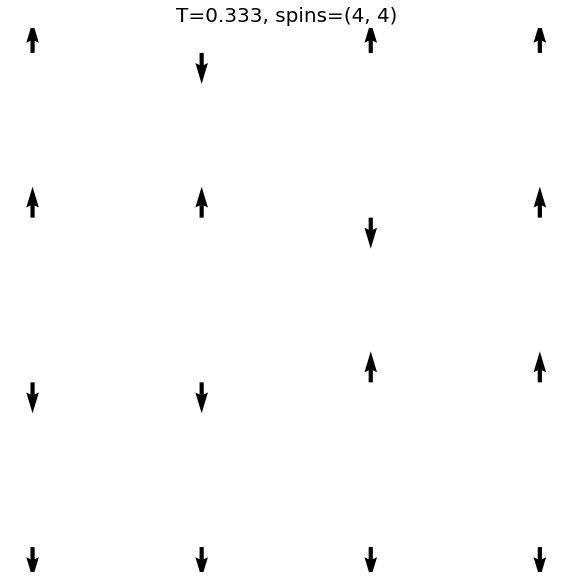

In [43]:
spin_viz(grid_1)

In [45]:
### Burning-in stage
time_start = time.time()
num_steps = 10000
_, m_history_1, energy_history_1 = full_evv_m(grid_1, num_steps)
time_end = time.time()
print(f"Time used for 1E5 steps is: {time_end-time_start}.")

  0%|          | 0/10000 [00:00<?, ?it/s]

Time used for 1E5 steps is: 108.24770641326904.


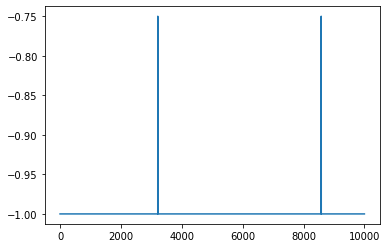

In [49]:
plt.plot(energy_history_1)

In [50]:
m_mean = np.mean(m_history_1)

In [51]:
print(f"abs mean of m is: {m_mean:.3f}.")

abs mean of m is: 0.001.


-----
### T = 2.269, Size = 8

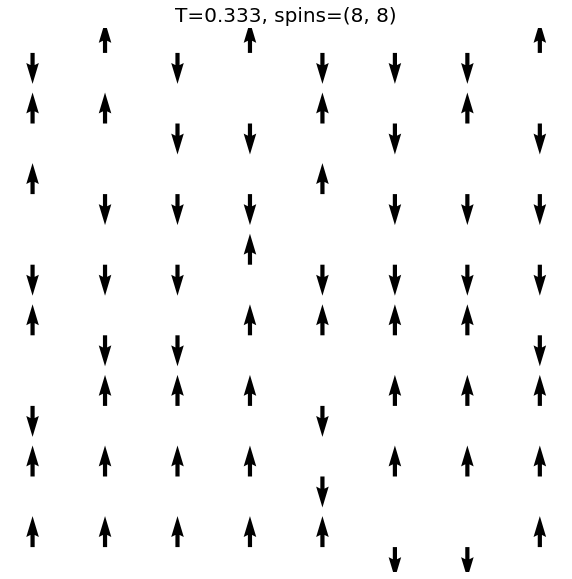

In [43]:
spin_viz(grid_1)

In [44]:
### Burning-in stage
time_start = time.time()
num_steps = 1000
_, m_history_1, energy_history_1 = full_evv_m(grid_1, num_steps)
time_end = time.time()
print(f"Time used for 1E5 steps is: {time_end-time_start}.")

  0%|          | 0/1000 [00:00<?, ?it/s]

Time used for 1E5 steps is: 57.677353858947754.


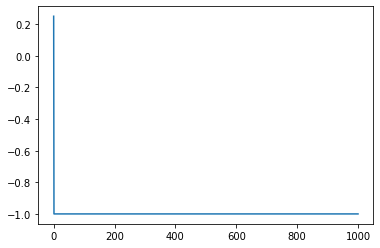

In [45]:
plt.plot(energy_history_1)

In [46]:
m_mean = np.mean(m_history_1)

In [47]:
print(f"mean of m is: {m_mean:.3f}.")

mean of m is: -0.006.


-----------------------